<a href="https://colab.research.google.com/github/ktatikon/MLproject/blob/main/NLP_milestone_project_2_SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mile stone project 2: SkimLit 
In the previous notebook (NLP fundamentals in TensorFlow), we went through some fundamental natural lanuage processing concepts. The main ones being tokenzation (turning words into numbers) and creating embeddings (creating a numerical representation of words).

In this project, we're going to be putting what we've learned into practice.

More specificially, we're going to be replicating the deep learning model behind the 2017 paper PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts.

When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

In other words, given the abstract of a RCT, what role does each sentence serve in the abstract?



**Problem in a sentence**

The number of RCT papers released is continuing to increase, those without structured abstracts can be hard to read and in turn slow down researchers moving through the literature.

Solution in a sentence

Create an NLP model to classify abstract sentences into the role they play (e.g. objective, methods, results, etc) to enable researchers to skim through the literature (hence SkimLit 🤓🔥) and dive deeper when necessary.

📖 Resources: Before going through the code in this notebook, you might want to get a background of what we're going to be doing. To do so, spend an hour (or two) going through the following papers and then return to this notebook:

Where our data is coming from: PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts
Where our model is coming from: [*Neural networks for joint sentence
classification in medical paper abstracts*](https://arxiv.org/pdf/1612.05251.pdf).

What we're going to cover

Time to take what we've learned in the NLP fundmentals notebook and build our biggest NLP model yet:

Downloading a text dataset (PubMed RCT200k from GitHub)
Writing a preprocessing function to prepare our data for modelling
Setting up a series of modelling experiments
Making a baseline (TF-IDF classifier)
Deep models with different combinations of: token embeddings, character embeddings, pretrained embeddings, positional embeddings
Building our first multimodal model (taking multiple types of data inputs)
Replicating the model architecture from https://arxiv.org/pdf/1612.05251.pdf
Find the most wrong predictions
Making predictions on PubMed abstracts from the wild
How you should approach this notebook

You can read through the descriptions and the code (it should all run, except for the cells which error on purpose), but there's a better option.

Write all of the code yourself.

Yes. I'm serious. Create a new notebook, and rewrite each line by yourself. Investigate it, see if you can break it, why does it break?

You don't have to write the text descriptions but writing the code yourself is a great way to get hands-on experience.

Don't worry if you make mistakes, we all do. The way to get better and make less mistakes is to write more code.

📖 Resource: See the full set of course materials on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning

Confirm access to a GPU

Since we're going to be building deep learning models, let's make sure we have a GPU.

In Google Colab, you can set this up by going to Runtime -> Change runtime type -> Hardware accelerator -> GPU.

If you don't have access to a GPU, the models we're building here will likely take up to 10x longer to run.

In [3]:
!nvidia-smi

Sat Jun  3 22:41:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e0ebf824-2afb-ee19-b0c5-21da3f3f9835)


# Get data
Before we can start building a model, we've got to download the PubMed 200k RCT dataset.

In a phenomenal act of kindness, the authors of the paper have made the data they used for their research availably publically and for free in the form of .txt files on GitHub.

We can copy them to our local directory using git clone https://github.com/Franck-Dernoncourt/pubmed-rct.

In [5]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 9.23 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [6]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [7]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/
##!ls pubmed-rct/PubMed

dev.txt  test.txt  train.zip


In [8]:
import zipfile
with zipfile.ZipFile("/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip","r") as zip_ref:
    zip_ref.extractall("/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/")

In [9]:
!ls pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt  train.zip


In [10]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


Beautiful, looks like we've got three separate text files:

train.txt - training samples.
dev.txt - dev is short for development set, which is another name for validation set (in our case, we'll be using and referring to this file as our validation set).

test.txt - test samples.
To save ourselves typing out the filepath to our target directory each time, let's turn it into a variable.

In [11]:

# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [12]:
# Check all of th efile names in the target dir
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

##Preprocess data

Okay, now we've downloaded some text data, do you think we're ready to model it?

Wait...

We've downloaded the data but we haven't even looked at it yet.

What's the motto for getting familiar with any new dataset?

I'll give you a clue, the word begins with "v" and we say it three times.

Vibe, vibe, vibe?

Sort of... we've definitely got to the feel the vibe of our data.

Values, values, values?

Right again, we want to see lots of values but not quite what we're looking for.

Visualize, visualize, visualize?

Boom! That's it. To get familiar and understand how we have to prepare our data for our deep learning models, we've got to visualize it.

Because our data is in the form of text files, let's write some code to read each of the lines in a target file.

In [13]:
# Create function to read the lines of a document

def get_lines(filename):
  """
  `reads filename(a text file) and returns the lines of the text as a list.
  Args:
    filename: a string containing the target filepath to read.

  returns:
    A list of the strings with one string per line from the target filename
  """
  with open(filename, 'r') as f:
    return f.readlines()

Alright, we've got a little function, get_lines() which takes the filepath of a text file, opens it, reads each of the lines and returns them.

Let's try it out on the training data (train.txt).

In [14]:
# Lets read in the training lines
train_lines = get_lines(data_dir+'train.txt') # read the lines with the training file

train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [15]:
len(train_lines)


210040

Reading the lines from the training text file results in a list of strings containing different abstract samples, the sentences in a sample along with the role the sentence plays in the abstract.

The role of each sentence is prefixed at the start of each line separated by a tab (\t) and each sentence finishes with a new line (\n).

Different abstracts are separated by abstract ID's (lines beginning with ###) and newlines (\n).

Knowing this, it looks like we've got a couple of steps to do to get our samples ready to pass as training data to our future machine learning model.

Let's write a function to perform the following steps:

Take a target file of abstract samples.
Read the lines in the target file.
For each line in the target file:
If the line begins with ### mark it as an abstract ID and the beginning of a new abstract.
Keep count of the number of lines in a sample.
If the line begins with \n mark it as the end of an abstract sample.
Keep count of the total lines in a sample.
Record the text before the \t as the label of the line.
Record the text after the \t as the text of the line.
Return all of the lines in the target text file as a list of dictionaries containing the key/value pairs:
  - "line_number" - the position of the line in the abstract (e.g. 3).
  - "target" - the role of the line in the abstract (e.g. OBJECTIVE).
  - "text" - the text of the line in the abstract.
  - "total_lines" - the total lines in an abstract sample (e.g. 14).

**Abstract ID's **and newlines should be omitted from the returned preprocessed data.
Example returned preprocessed sample (a single line from an abstract):

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
  ...]

In [16]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contains and sorts through each line,
  extracting things like the target label, the text of the sentence, 
  how many sentences are in the current abstract and of what sentence number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = ""# CREATE  an empty abstract 
  abstract_samples = [] #Create an empty list of abstracts

  #Loop through each line in the target file

  for line in input_lines:
    if line.startswith('###'): #check to see if there is an ID line
      abstract_id = line
      abstract_lines = "" #reset the abstract string if the line is an id line
    elif line.isspace(): # Check to if line is a new line
      abstract_line_split = abstract_lines.splitlines() #split abstract into seperate lines

      #Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} #create an empty dictionary for each line
        target_text_split = abstract_line.split('\t') # Split target label from text
        line_data['target'] = target_text_split[0] # get target label
        line_data['text'] = target_text_split[1].lower() # get the target text and lower it
        line_data['line_number'] = abstract_line_number # what number line does the line appear in the abstract?
        line_data['total_lines'] = len(abstract_line_split) -1 # how many total lines are there in the target abstract ? (start)
        abstract_samples.append(line_data) #add line data to abstract samples list
    else: # if the above conditions are't fulfilled , the line contains a labelled sentence
        abstract_lines += line
  return abstract_samples

In [17]:

txt = "Hello, welcome to my world."

x = txt.startswith("Hello")

print(x)

True


In [18]:
txt = "   "

x = txt.isspace()

print(x)

True


In [19]:
# get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt') # dev is another name for validation datatset
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')

print(len(train_samples), len(test_samples), len(val_samples))

180040 30135 30212
CPU times: user 308 ms, sys: 98.6 ms, total: 406 ms
Wall time: 403 ms


In [20]:
# check the first abstract of our training data
train_samples[:15]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Fantastic! Looks like our preprocess_text_with_line_numbers() function worked great.

How about we turn our list of dictionaries into pandas DataFrame's so we visualize them better?

In [21]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [22]:
# distribution of labels in training data

train_df.target.value_counts()


METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

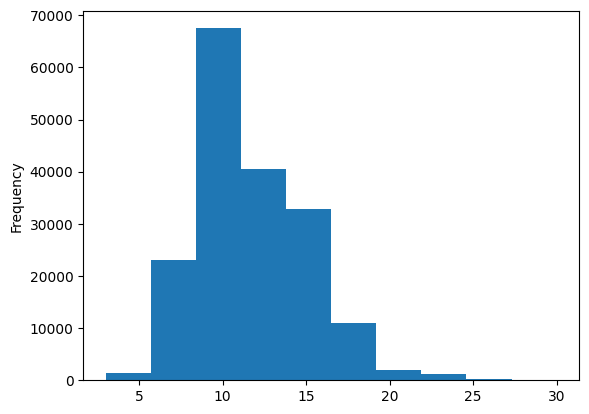

In [23]:
# lets check the length of the different lines
train_df.total_lines.plot.hist();

In [24]:
### get list of sentences 

In [25]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [26]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [27]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False) # We want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

#check what one hot encoded labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [28]:
import sklearn
print(sklearn.__version__)

1.2.2


In [29]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

##Label encode labels

In [30]:
# Extract labels ("target" columns) and encode them into integers 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
test_labels_encoded  = label_encoder.transform(test_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())

#check what training labels labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [31]:
# get Class names and number of calsses from LabelEncoder instance

num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

##Creating a series of model experiments

We've proprocessed our data so now, in true machine learning fashion, it's time to setup a series of modelling experiments.

We'll start by creating a simple baseline model to obtain a score we'll try to beat by building more and more complex models as we move towards replicating the sequence model outlined in Neural networks for joint sentence classification in medical paper abstracts.

For each model, we'll train it on the training data and evaluate it on the validation data.

##Model 0: Getting a baseline

Our first model we'll be a TF-IDF Multinomial Naive Bayes as recommended by Scikit-Learn's machine learning map.

To build it, we'll create a Scikit-Learn Pipeline which uses the TfidfVectorizer class to convert our abstract sentences to numbers using the TF-IDF (term frequency-inverse document frequecy) algorithm and then learns to classify our sentences using the MultinomialNB aglorithm.

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline

model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data

model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [33]:
# Evaluate baseline model on validation dataset... here we have to use score in sklearn instead of evaluate

model_0.score(X = val_sentences,
                 y = val_labels_encoded)

0.7218323844829869

In [34]:
# MAKE  PREDICTIONS using our baseline model

baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

To evaluate our baseline's predictions, we'll import the calculate_results() function we created in the previous notebook and added it to our helper_functions.py script to compare them to the ground truth labels.

More specificially the calculate_results() function will help us obtain the following:

Accuracy
Precision
Recall
F1-score
###Download helper functions script

Let's get our helper_functions.py script we've been using to store helper functions we've created in previous notebooks.

In [35]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-03 22:41:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-03 22:41:47 (106 MB/s) - ‘helper_functions.py’ saved [10246/10246]



Now we've got the helper functions script we can import the caculate_results() function and see how our baseline model went.

In [36]:

from helper_functions import calculate_results

In [37]:
# calculate baseline results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

###Preparing our data for deep sequence models

Excellent! We've got a working baseline to try and improve upon.

But before we start building deeper models, we've got to create vectorization and embedding layers.

The vectorization layer will convert our text to numbers and the embedding layer will capture the relationships between those numbers.

To start creating our vectorization and embedding layers, we'll need to import the appropriate libraries (namely TensorFlow and NumPy).

In [38]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [39]:
#How long is each sentence on average?

sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

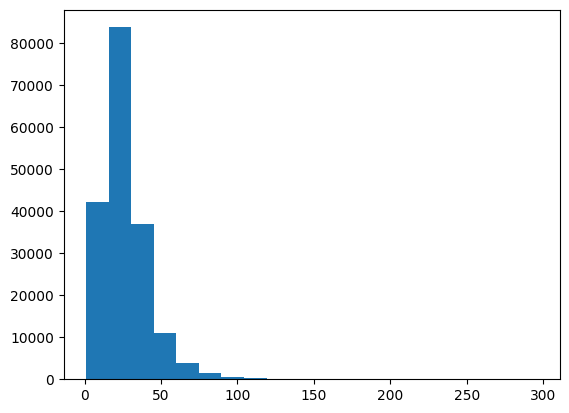

In [40]:
# whats the distribution look like?

import matplotlib.pyplot as plt
plt.hist(sent_lens, bins = 20);

In [41]:
# How long of a sentence length covers 95% of examples?

output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [42]:
#Maximum seqence length in the training set

max(sent_lens)

296

In [43]:
len(sent_lens)

180040

In [44]:
180040/296


608.2432432432432


### Create text vectorizer layer

we want to make a layer which maps our texts from words to numbers

To do so, we'll use the TextVectorization layer from TensorFlow.

We'll keep all the parameters default except for max_tokens (the number of unique words in our dataset) and output_sequence_length (our desired output length for each vectorized sentence).

Section 3.2 of the PubMed 200k RCT paper states the vocabulary size of the PubMed 20k dataset as 68,000. So we'll use that as our max_tokens parameter.

In [45]:
# How many words are in our vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000
     

In [46]:
from keras.api._v2.keras import preprocessing
# Create text vectorizer

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens, #number of words for vocabolary
                                    output_sequence_length = output_seq_len) # desired output length of vectorizer

In [47]:
# Adapt text vectorizer to training sentences

text_vectorizer.adapt(train_sentences)

In [48]:
# Test out text vectorizer on random sentences

import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of the text: {len(target_sentence.split())}")
print(f"\n Vectorized text: {text_vectorizer([target_sentence])}")

Text:
unconjugated bilirubin elevation , which favourably affects vascular biomarkers and cardiovascular disease risk in gilbert 's syndrome , occurs with atazanavir .

Length of the text: 22

 Vectorized text: [[24188  3250  1601   126 20670  1933   758   972     3   323   114    73
      5 38641   130   392  3333     7  9776     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [49]:
#How many words in our training vocabulary

rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]} ")


Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp'] 


In [50]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

###Create custom text embedding

Our token_vectorization layer maps the words in our text directly to numbers. However, this doesn't necessarily capture the relationships between those numbers.

To create a richer numerical representation of our text, we can use an embedding.

As our model learns (by going through many different examples of abstract sentences and their labels), it'll update its embedding to better represent the relationships between tokens in our corpus.

We can create a trainable embedding layer using TensorFlow's Embedding layer.

Once again, the main parameters we're concerned with here are the inputs and outputs of our Embedding layer.

The input_dim parameter defines the size of our vocabulary. And the output_dim parameter defines the dimension of the embedding output.

Once created, our embedding layer will take the integer outputs of our text_vectorization layer as inputs and convert them to feature vectors of size output_dim.

Let's see it in action.

In [51]:

tf.random.set_seed(42)
from tensorflow.keras import layers

token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab), # length of vocabulary
                             output_dim = 128, # Note: different embedding sizes result in drastically different numbers of pars
                             mask_zero = True,
                             name = 'token_embedding')# incase if your model has to do computing with lots of zeros like empty space filled with zeros then token embedding does the job well


# Show example embedding

print(f'Sentence before vectorization:\n{target_sentence}\n')
vectorized_sentence = text_vectorizer([target_sentence])

print(f'Sentence after vectorization(before embedding):\{vectorized_sentence}\n')
embedded_sentence = token_embed(vectorized_sentence)

print(f'Sentence after embedding:\n{embedded_sentence}\n')
print(f'Embedded sentence shape: {embedded_sentence.shape}')


Sentence before vectorization:
unconjugated bilirubin elevation , which favourably affects vascular biomarkers and cardiovascular disease risk in gilbert 's syndrome , occurs with atazanavir .

Sentence after vectorization(before embedding):\[[24188  3250  1601   126 20670  1933   758   972     3   323   114    73
      5 38641   130   392  3333     7  9776     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.01682757  0.02243903  0.03397498 ...  0.02135465  0.00315678
   -0.00542101]
  [-0.04068873 -0.01169425  0.03295116 ... -0.01001445 -0.00215381
    0.00896698]
  [-0.03066972  0.03049662 -0.04330471 ... -0.02985382  0.03037268
   -0.03032544]
  ...
  [ 0.04792049 -0.03228614 -0.03663343 ... -0.01931458 -0.03882816
    0.00145284]
  [ 0.04792049 -0.03228614 -0.03663343 ... -0.01931

###Create datasets (as fast as possible)

We've gone through all the trouble of preprocessing our datasets to be used with a machine learning model, however, there are still a few steps we can use to make them work faster with our models.

Namely, the tf.data API provides methods which enable faster data loading.

📖 *Resource: *For best practices on data loading in TensorFlow, check out the following:

 - tf.data: Build TensorFlow input pipelines
 - Better performance with the tf.data API
The main steps we'll want to use with our data is to turn it into a PrefetchDataset of batches.

Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.

To create a batched PrefetchDataset we can use the methods batch() and prefetch(), the parameter tf.data.AUTOTUNE will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [52]:
#Turn our data into TensorFlow datasets

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))

valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))

test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [53]:
train_labels_one_hot.shape, train_labels_one_hot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

In [54]:
# Take the TensorSliceDataset's and turn them into prefetched batches

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

###Model 1: Conv1D with token embeddings

Alright, we've now got a way to numerically represent our text and labels, time to build a series of deep models to try and improve upon our baseline.

All of our deep models will follow a similar structure:

     Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
The main component we'll be changing throughout is the Layers component. Because any modern deep NLP model requires text to be converted into an embedding before meaningful patterns can be discovered within.

The first model we're going to build is a 1-dimensional Convolutional Neural Network.

We're also going to be following the standard machine learning workflow of:

 - Build model
 - Train model
 - Evaluate model (make predictions and compare to ground truth)

In [55]:
# Create 1D convolutional model to process 

inputs = layers.Input(shape = (1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs) # Vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embeddings

x = layers.Conv1D(64, kernel_size = 5, padding ='same', activation = 'relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)# condense the output of our feature vector
outputs = layers.Dense(num_classes, activation = 'softmax')(x)

model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss = 'categorical_crossentropy', # if your labels are integer form (not one hot) use sparse_categorica
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [56]:
# Get the summary

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

Wonderful! We've got our first deep sequence model built and ready to go.

Checking out the model summary, you'll notice the majority of the trainable parameters are within the embedding layer. If we were to increase the size of the embedding (by increasing the output_dim parameter of the Embedding layer), the number of trainable parameters would increase dramatically.

It's time to fit our model to the training data but we're going to make a mindful change.

Since our training data contains nearly 200,000 sentences, fitting a deep model may take a while even with a GPU. So to keep our experiments swift, we're going to run them on a subset of the training dataset.

More specifically, we'll only use the first 10% of batches (about 18,000 samples) of the training set to train on and the first 10% of batches from the validation set to validate on.

🔑 Note: It's a standard practice in machine learning to test your models on smaller subsets of data first to make sure they work before scaling them to larger amounts of data. You should aim to run many smaller experiments rather than only a handful of large experiments. And since your time is limited, one of the best ways to run smaller experiments is to reduce the amount of data you're working with (10% of the full dataset is usually a good amount, as long as it covers a similar distribution).

In [57]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches
     

Epoch 1/3
562/562 [==============================] - 44s 61ms/step - loss: 0.9202 - accuracy: 0.6411 - val_loss: 0.6868 - val_accuracy: 0.7387
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 0.6599 - accuracy: 0.7553 - val_loss: 0.6395 - val_accuracy: 0.7653
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6204 - accuracy: 0.7736 - val_loss: 0.5999 - val_accuracy: 0.7806


Brilliant! We've got our first trained deep sequence model, and it didn't take too long (and if we didn't prefetch our batched data, it would've taken longer).

Time to make some predictions with our model and then evaluate them.

In [58]:
# # Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6017 - accuracy: 0.7837


[0.6017255783081055, 0.783728301525116]

In [59]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)

model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 3s 3ms/step


(array([[4.1147301e-01, 1.9269852e-01, 5.6947567e-02, 3.1638065e-01,
         2.2500249e-02],
        [4.4854084e-01, 2.6477164e-01, 1.3665236e-02, 2.6330999e-01,
         9.7123347e-03],
        [1.3692553e-01, 6.7151105e-03, 1.8687395e-03, 8.5443264e-01,
         5.7918372e-05],
        ...,
        [4.2045508e-06, 7.3108578e-04, 1.0898544e-03, 5.2962928e-06,
         9.9816954e-01],
        [7.3582880e-02, 4.3116960e-01, 9.2797026e-02, 9.1399938e-02,
         3.1105047e-01],
        [1.6855706e-01, 7.3234355e-01, 3.9026856e-02, 2.7850132e-02,
         3.2222439e-02]], dtype=float32),
 (30212, 5))

In [60]:
#convert pred probs to classes

model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [61]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [62]:
# calculate results

model_1_results = calculate_results(y_true = val_labels_encoded,
                                   y_pred = model_1_preds)

model_1_results

{'accuracy': 78.37283198728981,
 'precision': 0.7809036204844532,
 'recall': 0.7837283198728981,
 'f1': 0.7813722274920841}

###Model 2: Feature extraction with pretrained token embeddings

Training our own embeddings took a little while to run, slowing our experiments down.

Since we're moving towards replicating the model architecture in Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, it mentions they used a pretrained GloVe embedding as a way to initialise their token embeddings.

To emulate this, let's see what results we can get with the pretrained Universal Sentence Encoder embeddings from TensorFlow Hub.

🔑 *Note:* We could use GloVe embeddings as per the paper but since we're working with TensorFlow, we'll use what's available from TensorFlow Hub (GloVe embeddings aren't). We'll save using pretrained GloVe embeddings as an extension.

The model structure will look like:
   Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)
  
You'll notice the lack of tokenization layer we've used in a previous model. This is because the Universal Sentence Encoder (USE) takes care of tokenization for us.

This type of model is called transfer learning, or more specifically, feature extraction transfer learning. In other words, taking the patterns a model has learned elsewhere and applying it to our own problem.

The feature extractor model we're building using a pretrained embedding from TensorFlow Hub.

To download the pretrained USE into a layer we can use in our model, we can use the hub.KerasLayer class.

We'll keep the pretrained embeddings frozen (by setting trainable=False) and add a trainable couple of layers on the top to tailor the model outputs to our own data.

🔑 *Note*: Due to having to download a relatively large model (~916MB), the cell below may take a little while to run.

In [63]:
# Download pretrained TensorFlow Hub USE

import tensorflow_hub as hub

tf_hub_embedding_layer  = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                         trainable =False,
                                         name = 'universal_sentence_encoder')

Beautiful, now our pretrained USE is downloaded and instantiated as a hub.KerasLayer instance, let's test it out on a random sentence.

In [64]:
# Test out the embedding on a random sentence

random_training_sentence = random.choice(train_sentences)
print(f'Random training sentence:\n{random_training_sentence}\n')

use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])

print(f'Sentence After embedding:\n{use_embedded_sentence[0][:30]} (truncated output)....\n')

print(f'Length of sentence embedding:\n{len(use_embedded_sentence[0])}')

Random training sentence:
paliperidone group had significant greater reduction in panss than aripiprazole group and ziprasidone group from @ weeks , although the a reduction in panss of each group was more than @ % .

Sentence After embedding:
[-0.0361363  -0.03582443  0.03807597 -0.06802018 -0.06371223  0.04999993
 -0.01904625 -0.07597417 -0.03382091  0.00329959  0.03678096 -0.02280747
  0.03553961 -0.07088168  0.02636447  0.04462564  0.00964688 -0.045522
 -0.00848194  0.02203226 -0.0241366  -0.02012317 -0.04909168 -0.04147496
 -0.02490739  0.02661656 -0.00621101  0.01820282  0.00248951  0.01792803] (truncated output)....

Length of sentence embedding:
512


### Building and fitting an NLP extraction model Using pretrained embeddings from tensorflow HUB

In [65]:
# Define feature extractor model using TF Hub layer

inputs  = layers.Input(shape = [], dtype = tf.string)

pretrained_embedding = tf_hub_embedding_layer(inputs)# tokenize text and create embedding
x = layers.Dense(128, activation = 'relu')(pretrained_embedding)# add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to

outputs = layers.Dense(5, activation = 'softmax')(x) # create the output layer
model_2 = tf.keras.Model(inputs = inputs,
                            outputs = outputs)

# Compile
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [66]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [67]:
# Fit

model_2.fit(train_dataset,
            steps_per_epoch = int(0.1*len(train_dataset)),
            epochs = 3,
            validation_data = valid_dataset,
            validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 15s 22ms/step - loss: 0.9160 - accuracy: 0.6516 - val_loss: 0.7964 - val_accuracy: 0.6895
Epoch 2/3
562/562 [==============================] - 14s 25ms/step - loss: 0.7695 - accuracy: 0.7002 - val_loss: 0.7559 - val_accuracy: 0.7051
Epoch 3/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7563 - accuracy: 0.7099 - val_loss: 0.7420 - val_accuracy: 0.7081


In [68]:
# evaluate on whole on validation dataset 

model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.7445 - accuracy: 0.7110


[0.7444712519645691, 0.7110419869422913]

Since we aren't training our own custom embedding layer, training is much quicker.

Let's make some predictions and evaluate our feature extraction model.

In [69]:
# # Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 11s 11ms/step


array([[0.43717584, 0.34158036, 0.0020565 , 0.21169832, 0.00748901],
       [0.30821294, 0.53504544, 0.00243391, 0.15151386, 0.0027938 ],
       [0.23462981, 0.16210493, 0.01745361, 0.54405993, 0.04175177],
       ...,
       [0.00204126, 0.00560952, 0.07080092, 0.00095048, 0.92059785],
       [0.0043661 , 0.05116585, 0.1898286 , 0.00139126, 0.7532482 ],
       [0.17130324, 0.28812543, 0.4812765 , 0.0048674 , 0.05442752]],
      dtype=float32)

In [70]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis = 1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [71]:
# Calculate results from TF Hub pretrained embeddings results on validation set

model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_2_preds)

model_2_results

{'accuracy': 71.10419700781146,
 'precision': 0.7120809328644994,
 'recall': 0.7110419700781146,
 'f1': 0.7080057850130168}

###Model 3: Conv1D with character embeddings

###Creating a character-level tokenizer

The Neural Networks for Joint Sentence Classification in Medical Paper Abstracts paper mentions their model uses a hybrid of token and character embeddings.

We've built models with a custom token embedding and a pretrained token embedding, how about we build one using a character embedding?

The difference between a character and token embedding is that the character embedding is created using sequences split into characters (e.g. hello -> [h, e, l, l, o]) where as a token embedding is created on sequences split into tokens.

Token level embeddings split sequences into tokens (words) and embeddings each of them, character embeddings split sequences into characters and creates a feature vector for each.

We can create a character-level embedding by first vectorizing our sequences (after they've been split into characters) using the TextVectorization class and then passing those vectorized sequences through an Embedding layer.

Before we can vectorize our sequences on a character-level we'll need to split them into characters. Let's write a function to do so.

In [72]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))


  # Test splitting non-character-level sequence into characters

split_chars(random_training_sentence)

'p a l i p e r i d o n e   g r o u p   h a d   s i g n i f i c a n t   g r e a t e r   r e d u c t i o n   i n   p a n s s   t h a n   a r i p i p r a z o l e   g r o u p   a n d   z i p r a s i d o n e   g r o u p   f r o m   @   w e e k s   ,   a l t h o u g h   t h e   a   r e d u c t i o n   i n   p a n s s   o f   e a c h   g r o u p   w a s   m o r e   t h a n   @   %   .'

In [73]:
# Split sequence-level data splits into character-level data splits

train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


To figure out how long our vectorized character sequences should be, let's check the distribution of our character sequence lengths.

In [74]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

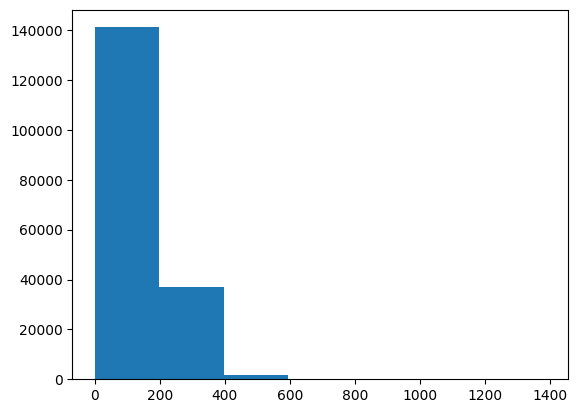

In [75]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins = 7);

Okay, looks like most of our sequences are between 0 and 200 characters long.

Let's use NumPy's percentile to figure out what length covers 95% of our sequences.

In [76]:
# Find what character length covers 95% of sequences

output_seq_char_len = int(np.percentile(char_lens, 95))

output_seq_char_len

290

Wonderful, now we know the sequence length which covers 95% of sequences, we'll use that in our TextVectorization layer as the output_sequence_length parameter.

🔑 Note: You can experiment here to figure out what the optimal output_sequence_length should be, perhaps using the mean results in as good results as using the 95% percentile.

We'll set max_tokens (the total number of different characters in our sequences) to 28, in other words, 26 letters of the alphabet + space + OOV (out of vocabulary or unknown) tokens.

In [77]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet


'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [78]:
random.choice(train_sentences)

"hcws were directly observed and asked to explain episodes of noncompliance in `` real-time . ''"

In [79]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS= len(alphabet) + 2  # num characters in alphabet + space + OOV token

char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    standardize = 'lower_and_strip_punctuation',
                                    name = 'char_vectorizer')

#Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

Nice! Now we've adapted our char_vectorizer to our character-level sequences, let's check out some characteristics about it using the get_vocabulary() method.

In [80]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()

print(f"Number of different characters in character vocab:{len(char_vocab)}")
print(f'5. most common characters:{char_vocab[:5]}')
print(f'5 least common charatcers:{char_vocab[-5:]}')

Number of different characters in character vocab:28
5. most common characters:['', '[UNK]', 'e', 't', 'i']
5 least common charatcers:['k', 'x', 'z', 'q', 'j']


We can also test it on random sequences of characters to make sure it's working.

In [81]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f'Charified text:\n{random_train_chars}')
print(f'\nLength of chars: {len(random_train_chars.split())}')

vectorized_chars = char_vectorizer([random_train_chars])
print(f'\nVectorized chars:\n{vectorized_chars}')
print(f'\nLength of vectorized chars: {len(vectorized_chars[0])}')

Charified text:
e n t e r a l   n u t r i t i o n   i s   o n e   o f   t h e   m a j o r   r i s k   f a c t o r s   f o r   v e n t i l a t o r - a s s o c i a t e d   p n e u m o n i a   .

Length of chars: 76

Vectorized chars:
[[ 2  6  3  2  8  5 12  6 16  3  8  4  3  4  7  6  4  9  7  6  2  7 17  3
  13  2 15  5 27  7  8  8  4  9 23 17  5 11  3  7  8  9 17  7  8 21  2  6
   3  4 12  5  3  7  8  5  9  9  7 11  4  5  3  2 10 14  6  2 16 15  7  6
   4  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0

You'll notice sequences with a length shorter than 290 (output_seq_char_length) get padded with zeros on the end, this ensures all sequences passed to our model are the same length.

Also, due to the standardize parameter of TextVectorization being "lower_and_strip_punctuation" and the split parameter being "whitespace" by default, symbols (such as @) and spaces are removed.

      🔑 Note:If you didn't want punctuation to be removed (keep the @, % etc), you can create a custom standardization callable and pass it as the standardize parameter. See the TextVectorization layer documentation for more.

###Creating a character-level embedding

We've got a way to vectorize our character-level sequences, now's time to create a character-level embedding.

Just like our custom token embedding, we can do so using the tensorflow.keras.layers.Embedding class.

Our character-level embedding layer requires an input dimension and output dimension.

The input dimension (input_dim) will be equal to the number of different characters in our char_vocab (28). And since we're following the structure of the model in Figure 1 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, the output dimension of the character embedding (output_dim) will be 25.

In [82]:
# Create char embedding layer

char_embed = layers.Embedding(input_dim = NUM_CHAR_TOKENS,# number of different characters
                              output_dim = 25,#this is the size of the char embedding in the paper: https://arxiv.org/pdf/1612.05251.pdf embedding dimension of each character (same as Figure 1 i
                              mask_zero = False, # don't use masks (this messes up model_5 if set to True)
                              name = 'char_embed')

## Test out character embedding layer
print(f'Charified text(before vectorization and embedding:\n{random_train_chars}\n)')

char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f'Embedded chars (after vectorization and embedding):\n{char_embed_example}\n')
print(f"Character embedding shape:{char_embed_example.shape}")

Charified text(before vectorization and embedding:
e n t e r a l   n u t r i t i o n   i s   o n e   o f   t h e   m a j o r   r i s k   f a c t o r s   f o r   v e n t i l a t o r - a s s o c i a t e d   p n e u m o n i a   .
)
Embedded chars (after vectorization and embedding):
[[[ 0.01743576  0.01112432 -0.04038985 ... -0.00993308  0.03077186
   -0.00960275]
  [-0.04320767 -0.0424976  -0.04308484 ... -0.00323408  0.0436797
    0.01732126]
  [-0.0386075   0.0221636   0.0162133  ...  0.02572415 -0.01361538
   -0.01601558]
  ...
  [ 0.04687211  0.04258512  0.04769516 ...  0.01706704 -0.04137154
   -0.0253937 ]
  [ 0.04687211  0.04258512  0.04769516 ...  0.01706704 -0.04137154
   -0.0253937 ]
  [ 0.04687211  0.04258512  0.04769516 ...  0.01706704 -0.04137154
   -0.0253937 ]]]

Character embedding shape:(1, 290, 25)


Wonderful! Each of the characters in our sequences gets turned into a 25 dimension embedding.

###Building a Conv1D model to fit on character embeddings

Now we've got a way to turn our character-level sequences into numbers (char_vectorizer) as well as numerically represent them as an embedding (char_embed) let's test how effective they are at encoding the information in our sequences by creating a character-level sequence model.

The model will have the same structure as our custom token embedding model (model_1) except it'll take character-level sequences as input instead of token-level sequences.

      Input (character-level text) -> Tokenize -> Embedding -> Layers (Conv1D, GlobalMaxPool1D) -> Output (label probability)

In [83]:
len(random_train_chars)

175

In [84]:
# Make Conv1D on chars only

inputs = layers.Input(shape = (1,), dtype = 'string')
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding ='same', activation = 'relu')(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, 
                       activation = 'softmax')(x)
model_3 = tf.keras.Model(inputs = inputs,
                         outputs  = outputs,
                         name = 'model_3_conv1d_char_embeddings')

#Compile
model_3.compile(loss = 'categorical_crossentropy',
                optimizer = 'Adam',
                metrics= ['accuracy'])

In [85]:
#GEt summary
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 

Before fitting our model on the data, we'll create char-level batched PrefetchedDataset's.

In [86]:
# Create char datasets

train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset


<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [87]:
model_3_history = model_3.fit(train_char_dataset,
                             steps_per_epoch = int(0.1*len(train_char_dataset)),
                             epochs = 3,
                             validation_data = val_char_dataset,
                             validation_steps = int(0.1*len(val_char_dataset)))
                                                   

Epoch 1/3
562/562 [==============================] - 6s 8ms/step - loss: 1.2386 - accuracy: 0.4979 - val_loss: 1.0291 - val_accuracy: 0.5871
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0101 - accuracy: 0.5882 - val_loss: 0.9459 - val_accuracy: 0.6220
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9353 - accuracy: 0.6311 - val_loss: 0.8757 - val_accuracy: 0.6589


In [88]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.8984 - accuracy: 0.6486


[0.8984255790710449, 0.648550271987915]

Nice! Looks like our character-level model is working, let's make some predictions with it and evaluate them.

In [89]:
# Make predictions with character model only

mode_3_pred_probs = model_3.predict(val_char_dataset)

mode_3_pred_probs

945/945 [==============================] - 3s 4ms/step


array([[0.1086816 , 0.40130344, 0.05663094, 0.3147367 , 0.11864736],
       [0.20309414, 0.3965889 , 0.01452536, 0.29450193, 0.09128967],
       [0.14182991, 0.35628483, 0.10647609, 0.29421157, 0.10119764],
       ...,
       [0.01814304, 0.03068565, 0.06429549, 0.01507446, 0.8718014 ],
       [0.02659152, 0.09898108, 0.37987506, 0.03798386, 0.4565685 ],
       [0.42037958, 0.26065508, 0.13760544, 0.16713302, 0.0142268 ]],
      dtype=float32)

In [90]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_1_pred_probs, axis = 1)

model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [91]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 78.37283198728981,
 'precision': 0.7809036204844532,
 'recall': 0.7837283198728981,
 'f1': 0.7813722274920841}

In [92]:
model_3_results

{'accuracy': 78.37283198728981,
 'precision': 0.7809036204844532,
 'recall': 0.7837283198728981,
 'f1': 0.7813722274920841}

###Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)



Alright, now things are going to get spicy.

In moving closer to build a model similar to the one in Figure 1 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, it's time we tackled the hybrid token embedding layer they speak of.

This hybrid token embedding layer is a combination of token embeddings and character embeddings. In other words, they create a stacked embedding to represent sequences before passing them to the sequence label prediction layer.

So far we've built two models which have used token and character-level embeddings, however, these two models have used each of these embeddings exclusively.

To start replicating (or getting close to replicating) the model in Figure 1, we're going to go through the following steps:

 - Create a token-level model (similar to model_1)
 - Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
 - Combine (using layers.Concatenate) the outputs of 1 and 2
 - Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of [*Neural Networks for Joint Sentence Classification in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf) 
 - Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [93]:
# 1. Setup the token input/model

token_inputs = layers.Input(shape = [], dtype  = tf.string, name = 'token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation = 'relu' )(token_embeddings)
token_model = tf.keras.Model(inputs = inputs,
                             outputs = outputs)

#2. setup char inputs/model

char_inputs = layers.Input(shape = (1,), dtype = tf.string, name = 'char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)# bi-LSTM shown in Figure 1 o
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

#3. Concatenate token and char inputs (create hybrid token embedding)

token_char_concat = layers.Concatenate(name = 'token_char_hybrid')([token_model.output,
                                                                   char_model.output])


#4. Create output layers - addition of dropout discussedin 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation = 'relu')(combined_dropout)# slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation = 'softmax')(final_dropout)


#5. Construct model with char and token inputs

model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                                   outputs = output_layer,
                                   name = 'model_4_token_and_char_embeddings')




Woah... There's a lot going on here, let's get a summary and plot our model to visualize what's happening.

In [94]:
# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_3[0][0]',                
 tion)                                                            'char_input[0][0]']             
                                                                                                  
 char_embed (Embedding)         (None, 290, 25)      1750        ['char_vectorizer[0][0]',        
                                                                  'char_vectorizer[1][0]']        
                                                                  

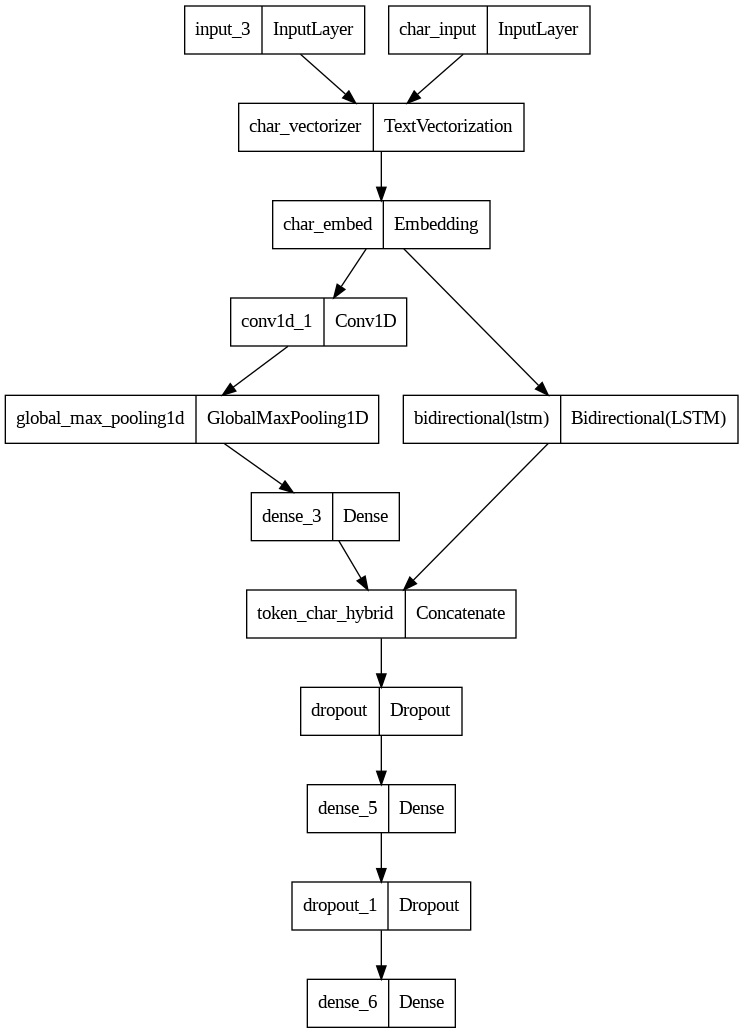

In [95]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

Now that's a good looking model. Let's compile it just as we have the rest of our models.

    🔑 Note: Section 4.2 of [*Neural Networks for Joint Sentence Classification

in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf) mentions using the SGD (stochastic gradient descent) optimizer, however, to stay consistent with our other models, we're going to use the Adam optimizer. As an exercise, you could try using tf.keras.optimizers.SGD instead of   tf.keras.optimizers.Adam and compare the results.

In [77]:


In [96]:
# Compile 

model_4.compile(loss ='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentio
                metrics = ['accuracy'])

And again, to keep our experiments fast, we'll fit our token-character-hybrid model on 10% of training and validate on 10% of validation batches. However, the difference with this model is that it requires two inputs, token-level sequences and character-level sequences.

We can do this by create a tf.data.Dataset with a tuple as it's first input, for example:

   - ((token_data, char_data), (label))
Let's see it in action.

##Combining token and character data into a tf.data dataset

In [97]:
# Combine chars and tokens into A dateset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))# make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))## combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))# make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))## combine data and labels
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 


In [98]:
# Check out training char and token embedding dataset

train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

##Fitting a model on token and character-level sequences

In [99]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset,# train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data= val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 23s 30ms/step - loss: 1.3642 - accuracy: 0.4209 - val_loss: 1.2142 - val_accuracy: 0.5136
Epoch 2/3
562/562 [==============================] - 14s 25ms/step - loss: 1.2427 - accuracy: 0.4809 - val_loss: 1.1380 - val_accuracy: 0.5342
Epoch 3/3
562/562 [==============================] - 14s 24ms/step - loss: 1.1904 - accuracy: 0.5058 - val_loss: 1.1157 - val_accuracy: 0.5412


In [100]:

# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 1.1104 - accuracy: 0.5404


[1.110389232635498, 0.5404475331306458]

Nice! Our token-character hybrid model has come to life!

To make predictions with it, since it takes multiplie inputs, we can pass the predict() method a tuple of token-level sequences and character-level sequences.

We can then evaluate the predictions as we've done before

In [101]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 15s 14ms/step


array([[0.32942232, 0.3056714 , 0.11389698, 0.1797349 , 0.07127442],
       [0.23552848, 0.25832337, 0.16733247, 0.20252952, 0.13628612],
       [0.26590714, 0.2314645 , 0.15168434, 0.287084  , 0.06385998],
       ...,
       [0.12884973, 0.30634364, 0.16003732, 0.05673327, 0.34803602],
       [0.09613352, 0.22265145, 0.21390623, 0.06742065, 0.3998881 ],
       [0.22127895, 0.4354998 , 0.09592694, 0.11073169, 0.1365626 ]],
      dtype=float32)

In [102]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [103]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 54.044750430292595,
 'precision': 0.5703544922732661,
 'recall': 0.540447504302926,
 'f1': 0.5416152525954672}

###Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

It seems like combining token embeddings and character embeddings gave our model a little performance boost.

But there's one more piece of the puzzle we can add in.

What if we engineered our own features into the model?

Meaning, what if we took our own knowledge about the data and encoded it in a numerical way to give our model more information about our samples?

The process of applying your own knowledge to build features as input to a model is called feature engineering.

Can you think of something important about the sequences we're trying to classify?

If you were to look at an abstract, would you expect the sentences to appear in order? Or does it make sense if they were to appear sequentially? For example, sequences labelled CONCLUSIONS at the beggining and sequences labelled OBJECTIVE at the end?



Abstracts typically come in a sequential order, such as:

 - OBJECTIVE ...
 - METHODS ...
 - METHODS ...
 - METHODS ...
 - RESULTS ...
 - CONCLUSIONS ...

Or

 - BACKGROUND ...
 - OBJECTIVE ...
 - METHODS ...
 - METHODS ...
 - RESULTS ...
 - RESULTS ...
 - CONCLUSIONS ...
 - CONCLUSIONS ...
Of course, we can't engineer the sequence labels themselves into the training data (we don't have these at test time), but we can encode the order of a set of sequences in an abstract.

For example,

Sentence 1 of 10 ...

Sentence 2 of 10 ...

Sentence 3 of 10 ...

Sentence 4 of 10 ...
...
You might've noticed this when we created our preprocess_text_with_line_numbers() function. When we read in a text file of abstracts, we counted the number of lines in an abstract as well as the number of each line itself.

Doing this led to the "line_number" and "total_lines" columns of our DataFrames.

In [107]:
# Inspect training dataframe
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


The "line_number" and "total_lines" columns are features which didn't necessarily come with the training data but can be passed to our model as a **positional embedding**. In other words, the positional embedding is where the sentence appears in an abstract.

We can use these features because they will be available at test time.

Since abstracts typically have a sequential order about them (for example, background, objective, methods, results, conclusion), it makes sense to add the line number of where a particular sentence occurs to our model. The beautiful thing is, these features will be available at test time (we can just count the number of sentences in an abstract and the number of each one).

Meaning, if we were to predict the labels of sequences in an abstract our model had never seen, we could count the number of lines and the track the position of each individual line and pass it to our model.

              🛠 Exercise: Another way of creating our positional embedding feature would be to combine the "line_number" and "total_lines" columns into one, for example a "line_position" column may contain values like 1_of_11, 2_of_11, etc. Where 1_of_11 would be the first line in an abstract 11 sentences long. After going through the following steps, you might want to revisit this positional embedding stage and see how a combined column of "line_position" goes against two separate columns.

###Create positional embeddings

Okay, enough talk about positional embeddings, let's create them.

Since our "line_number" and "total_line" columns are already numerical, we could pass them as they are to our model.

But to avoid our model thinking a line with "line_number"=5 is five times greater than a line with "line_number"=1, we'll use one-hot-encoding to encode our "line_number" and "total_lines" features.

To do this, we can use the tf.one_hot utility.

tf.one_hot returns a one-hot-encoded tensor. It accepts an array (or tensor) as input and the depth parameter determines the dimension of the returned tensor.

To figure out what we should set the depth parameter to, let's investigate the distribution of the "line_number" column.

    🔑 Note: When it comes to one-hot-encoding our features, Scikit-Learn's OneHotEncoder class is 
another viable option here.

In [108]:
# How many different line numbers are there?

train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

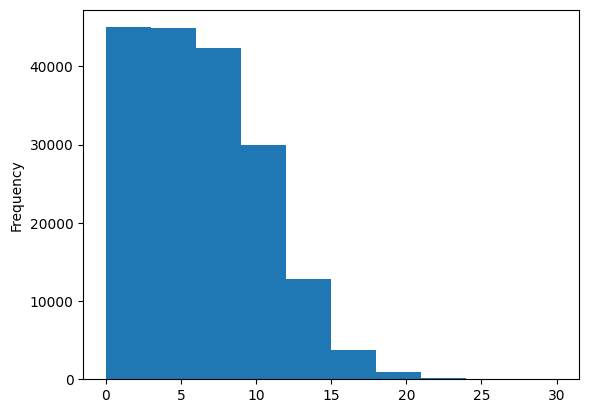

In [109]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

Looking at the distribution of the "line_number" column, it looks like the majority of lines have a position of 15 or less.

Knowing this, let's set the depth parameter of tf.one_hot to 15.

In [111]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column 

train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth = 15)

# Check one-hot encoded "line_number" feature samples

train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

Setting the depth parameter of tf.one_hot to 15 means any sample with a "line_number" value of over 15 gets set to a tensor of all 0's, where as any sample with a "line_number" of under 15 gets turned into a tensor of all 0's but with a 1 at the index equal to the "line_number" value.

    🔑 Note: We could create a one-hot tensor which has room for all of the potential values of "line_number" (depth=30), however, this would end up in a tensor of double the size of our current one (depth=15) where the vast majority of values are 0. Plus, only ~2,000/180,000 samples have a "line_number" value of over 15. So we would not be gaining much information about our data for doubling our feature space. This kind of problem is called the curse of dimensionality. However, since this we're working with deep models, it might be worth trying to throw as much information at the model as possible and seeing what happens. I'll leave exploring values of the depth parameter as an extension.

We can do the same as we've done for our "line_number" column witht he "total_lines" column. First, let's find an appropriate value for the depth parameter of tf.one_hot.


In [112]:
# How many different numbers of lines are there?
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

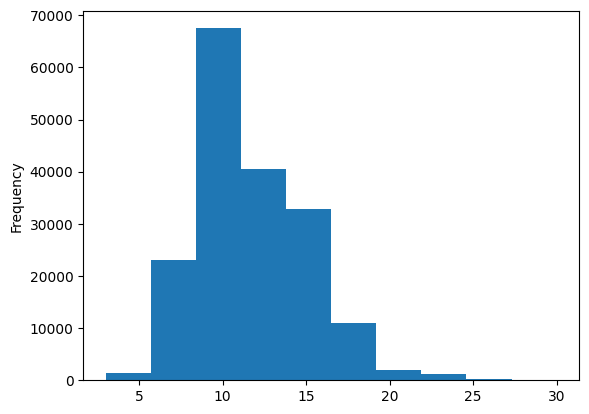

In [113]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

Looking at the distribution of our "total_lines" column, a value of 20 looks like it covers the majority of samples.

We can confirm this with np.percentile().

In [114]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples

20.0

Beautiful! Plenty of converage. Let's one-hot-encode our "total_lines" column just as we did our "line_number" column.

In [116]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth = 20)

train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

###Building a tribrid embedding model

Woohoo! Positional embedding tensors ready.

It's time to build the biggest model we've built yet. One which incorporates token embeddings, character embeddings and our newly crafted positional embeddings.

We'll be venturing into uncovered territory but there will be nothing here you haven't practiced before.

More specifically we're going to go through the following steps:

 1. Create a token-level model (similar to model_1)
 2. Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
 3. Create a "line_number" model (takes in one-hot-encoded "line_number" tensor and passes it through a non-linear layer)
 4. Create a "total_lines" model (takes in one-hot-encoded "total_lines" tensor and passes it through a non-linear layer)
 5. Combine (using layers.Concatenate) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of [*Neural Networks for Joint Sentence Classification in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf) 
 6. Combine (using layers.Concatenate) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding 
 7. Create an output layer to accept the tribrid embedding and output predicted label probabilities
 8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model

Woah! That's alot... but nothing we're not capable of. Let's code it.

In [119]:
# 1. Token inputs
token_inputs = layers.Input(shape = [], dtype = 'string', name= 'token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = 'relu')(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs)

#2. char inputs
char_inputs = layers.Input(shape = (1, ), dtype = 'string', name  = 'char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape = (15, ), dtype = tf.int32, name  = 'line_number_input')
x = layers.Dense(32, activation = 'relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs= x)

#4. Total lines inputs
total_lines_inputs = layers.Input(shape = (20,), dtype= tf.int32, name = 'total_lines_input')
y = layers.Dense(32, activation = 'relu')(total_lines_inputs)
total_line_model = tf.keras.Model(inputs = total_lines_inputs,
                                  outputs = y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name = 'token_char_hybrid_embedding')([token_model.output,
                                                                                char_model.output])

z = layers.Dense(256, activation = 'relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

#6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding

z = layers.Concatenate(name = 'token_char_potential_embedding')([line_number_model.output,
                                                                 total_line_model.output,
                                                                 z])

# 7. Create output layer
output_layer = layers.Dense(5, activation = 'softmax', name = 'output_layer')(z)

#8. put together model
model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_line_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs = output_layer)


There's a lot going on here... let's visualize what's happening with a summary by plotting our model.

In [120]:
model_5.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

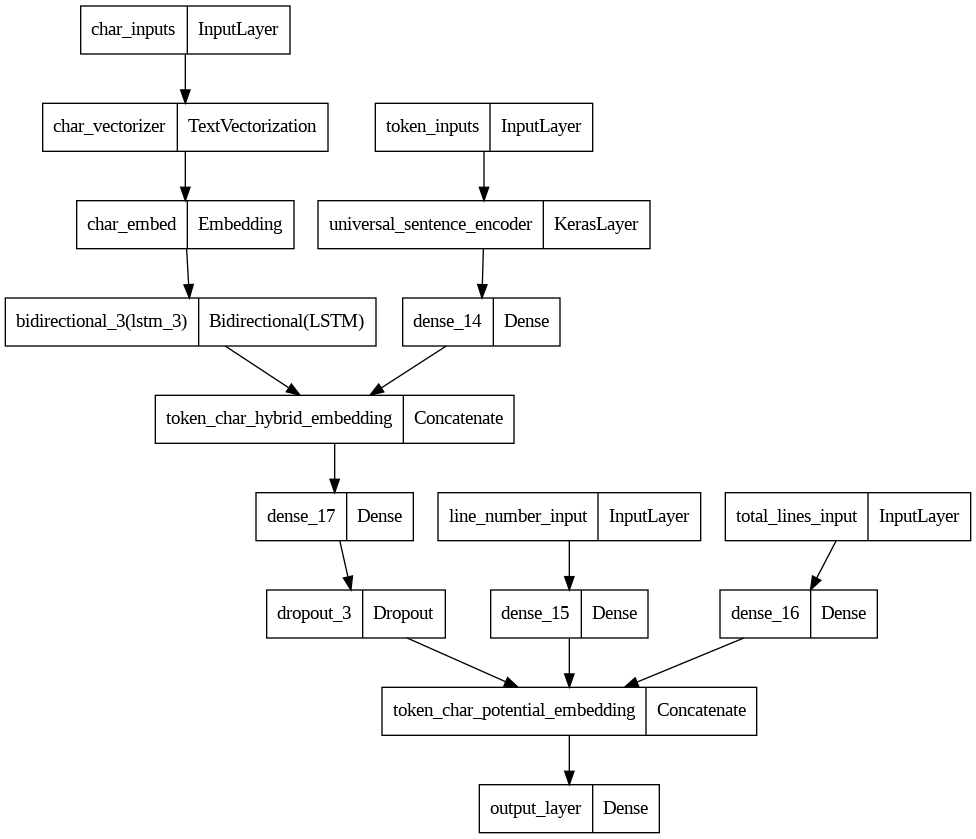

In [121]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

Visualizing the model makes it much easier to understand.

Essentially what we're doing is trying to encode as much information about our sequences as possible into various embeddings (the inputs to our model) so our model has the best chance to figure out what label belongs to a sequence (the outputs of our model).

You'll notice our model is looking very similar to the model shown in Figure 1 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts. However, a few differences still remain:

 - We're using pretrained TensorFlow Hub token embeddings instead of GloVe emebddings.
 - We're using a Dense layer on top of our token-character hybrid embeddings instead of a bi-LSTM layer.
 - Section 3.1.3 of the paper mentions a label sequence optimization layer (which helps to make sure sequence labels come out in a respectable order) but it isn't shown in Figure 1. To makeup for the lack of this layer in our model, we've created the positional embeddings layers.
 - Section 4.2 of the paper mentions the token and character embeddings are updated during training, our pretrained TensorFlow Hub embeddings remain frozen.
 - The paper uses the SGD optimizer, we're going to stick with Adam.


All of the differences above are potential extensions of this project.

In [122]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7feb486d7850> True
<keras.engine.input_layer.InputLayer object at 0x7feb48b477f0> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7fead9ef3b20> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7feb3396a590> False
<keras.layers.core.embedding.Embedding object at 0x7feaad1456c0> True
<keras.layers.core.dense.Dense object at 0x7feb48b46620> True
<keras.layers.rnn.bidirectional.Bidirectional object at 0x7feb48adf0a0> True
<keras.layers.merging.concatenate.Concatenate object at 0x7feb485d7b80> True
<keras.engine.input_layer.InputLayer object at 0x7feb486d4fa0> True
<keras.engine.input_layer.InputLayer object at 0x7feb484ea410> True
<keras.layers.core.dense.Dense object at 0x7feb485ccb50> True
<keras.layers.core.dense.Dense object at 0x7feb48b03a90> True
<keras.layers.core.dense.Dense object at 0x7feb484e9ff0> True
<keras.layers.regularization.dropout.Dropout object at 0x7feb485cd750> True
<keras.layers

Now our model is constructed, let's compile it.

This time, we're going to introduce a new parameter to our loss function called label_smoothing. Label smoothing helps to regularize our model (prevent overfitting) by making sure it doesn't get too focused on applying one particular label to a sample.

For example, instead of having an output prediction of:

 - [0.0, 0.0, 1.0, 0.0, 0.0] for a sample (the model is very confident the right label is index 2).
It's predictions will get smoothed to be something like:

 - [0.01, 0.01, 0.096, 0.01, 0.01] giving a small activation to each of the other labels, in turn, hopefully improving generalization.

    📖 Resource: For more on label smoothing, see the great blog post by 
    PyImageSearch, Label smoothing with Keras, TensorFlow, and Deep Learning.

Label smoothing with Keras, TensorFlow, and Deep Learning
https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/


    what is label smoothing?

    for ex: if our model gets too confident on a single class (eg, its prediction prbability is really high), it may get stuck on that class and not consider other classes....


    really confident [0.01, 0.01, 0.096, 0.01, 0.01]

In [123]:
# Compile token, char, positional embedding model
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

###Create tribrid embedding datasets and fit tribrid model

Model compiled!

Again, to keep our experiments swift, let's fit on 20,000 examples for 3 epochs.

This time our model requires four feature inputs:

1. Train line numbers one-hot tensor (train_line_numbers_one_hot)
2. Train total lines one-hot tensor (train_total_lines_one_hot)
3. Token-level sequences tensor (train_sentences)
4. Char-level sequences tensor (train_chars)

We can pass these as tuples to our tf.data.Dataset.from_tensor_slices() method to create appropriately shaped and batched PrefetchedDataset's.

In [126]:
# Create training and validation datasets (all four kinds of inputs)

train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,# line numbers
                                                               train_total_lines_one_hot,# total lines
                                                               train_sentences,# train tokens
                                                               train_chars))# train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset

val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,# line numbers
                                                               val_total_lines_one_hot,# total lines
                                                               val_sentences,# train tokens
                                                               val_chars))# train chars
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [127]:
# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [130]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch = int(0.1*len(train_pos_char_token_dataset)),
                              epochs = 3,
                              validation_data = val_pos_char_token_dataset,
                              validation_steps = int(0.1*len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 31s 43ms/step - loss: 1.0988 - accuracy: 0.7197 - val_loss: 0.9868 - val_accuracy: 0.8029
Epoch 2/3
562/562 [==============================] - 27s 48ms/step - loss: 0.9692 - accuracy: 0.8126 - val_loss: 0.9529 - val_accuracy: 0.8301
Epoch 3/3
562/562 [==============================] - 39s 69ms/step - loss: 0.9508 - accuracy: 0.8245 - val_loss: 0.9416 - val_accuracy: 0.8288


Tribrid model trained! Time to make some predictions with it and evaluate them just as we've done before.

In [131]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose = 1)
model_5_pred_probs

945/945 [==============================] - 26s 27ms/step


array([[0.4907023 , 0.11263873, 0.00758841, 0.3705789 , 0.01849164],
       [0.49733204, 0.10311413, 0.03325967, 0.3518235 , 0.01447072],
       [0.28449783, 0.12763974, 0.13248691, 0.39080134, 0.06457414],
       ...,
       [0.03478281, 0.11204077, 0.0403459 , 0.02860082, 0.7842297 ],
       [0.02719816, 0.26585844, 0.08994348, 0.02274338, 0.5942566 ],
       [0.13672064, 0.6539912 , 0.12341077, 0.03466937, 0.05120799]],
      dtype=float32)

In [132]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis = 1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [133]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_5_preds)

model_5_results

{'accuracy': 83.12260029127499,
 'precision': 0.8305720090757929,
 'recall': 0.83122600291275,
 'f1': 0.8305348928784306}

###Compare model results

Far out, we've come a long way. From a baseline model to training a model containing three different kinds of embeddings.

Now it's time to compare each model's performance against each other.

We'll also be able to compare our model's to the PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper.

Since all of our model results are in dictionaries, let's combine them into a pandas DataFrame to visualize them.

In [135]:

# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results
     

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.372832,0.780904,0.783728,0.781372
pretrained_token_embed,71.104197,0.712081,0.711042,0.708006
custom_char_embed_conv1d,78.372832,0.780904,0.783728,0.781372
hybrid_char_token_embed,54.044750,0.570354,0.540448,0.541615
tribrid_pos_char_token_embed,83.122600,0.830572,0.831226,0.830535


In [136]:
# Reduce the accuracy to same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy']/100

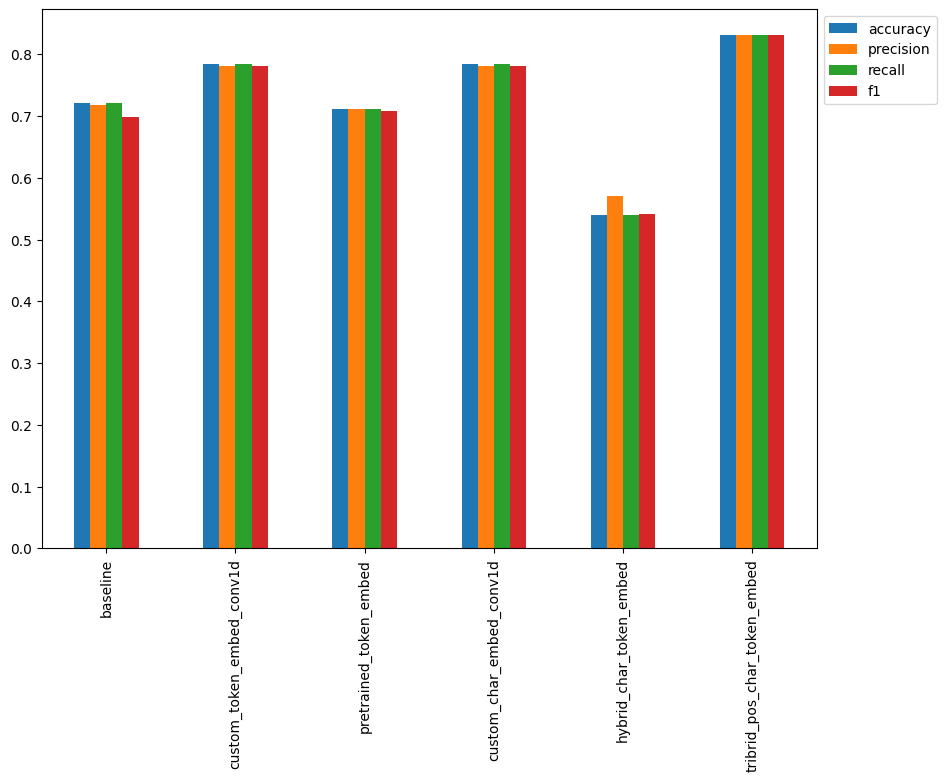

In [137]:
# Plot and compare all of the model results
all_model_results.plot(kind = 'bar', figsize = (10,7)).legend(bbox_to_anchor = (1.0, 1.0));

Since the PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper compares their tested model's F1-scores on the test dataset, let's take at our model's F1-scores.

    🔑 Note: We could've also made these comparisons in TensorBoard using the 
      TensorBoard callback during training.

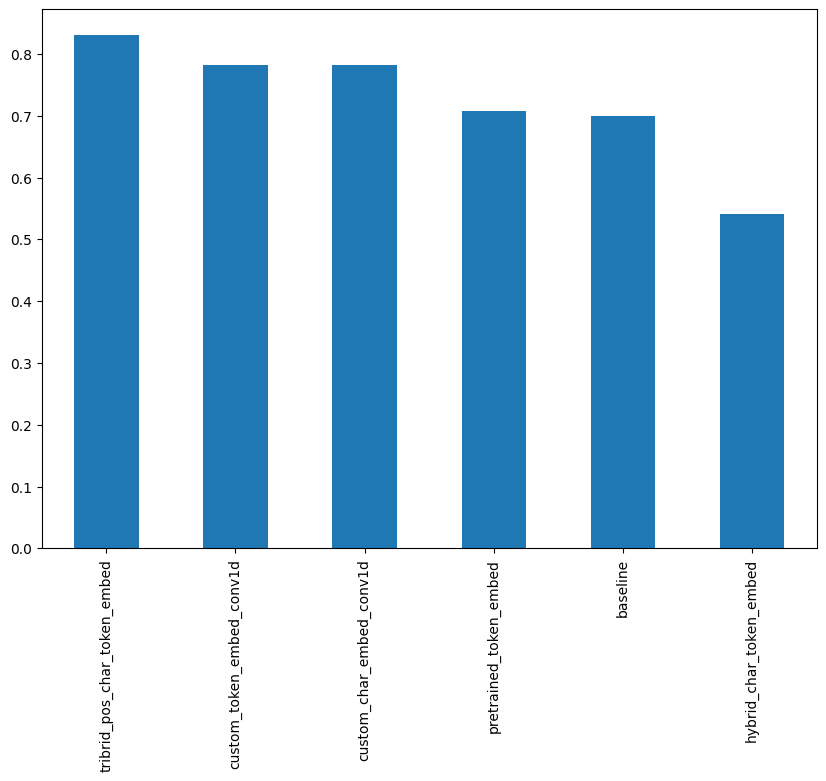

In [138]:
# Sort model results by f1-score
all_model_results.sort_values('f1', ascending = False)['f1'].plot(kind = 'bar', figsize = (10, 7));




Nice! Based on F1-scores, it looks like our tribrid embedding model performs the best by a fair margin.

Though, in comparison to the results reported in Table 3 of the PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper, our model's F1-score is still underperforming (the authors model achieves an F1-score of 90.0 on the 20k RCT dataset versus our F1-score of ~82.6).

There are some things to note about this difference:

 - Our models (with an exception for the baseline) have been trained on ~18,000 
  (10% of batches) samples of sequences and labels rather than the full ~180,000 
  in the 20k RCT dataset.
       - This is often the case in machine learning experiments though, 
       make sure training works on a smaller number of samples, then upscale when 
       needed (an extension to this project will be training a model on the full \
               dataset).
 - Our model's prediction performance levels have been evaluated on the validation 
 dataset not the test dataset (we'll evaluate our best model on the test dataset 
 shortly).

##Save and load best performing model

Since we've been through a fair few experiments, it's a good idea to save our best performing model so we can reuse it without having to retrain it.

We can save our best performing model by calling the save() method on it.

In [140]:
# Save best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model") # model will be saved to path specified by string

In [141]:
# Example of copying saved model from Google Colab to Drive (requires Google Drive to be mounted)
# !cp skimlit_best_model -r /content/drive/MyDrive/tensorflow_course/skim_lit

Like all good cooking shows, we've got a pretrained model (exactly the same kind of model we built for model_5 saved and stored on Google Drive and Google Storage).

So to make sure we're all using the same model for evaluation, we'll download it and load it in.

And when loading in our model, since it uses a couple of custom objects (our TensorFlow Hub layer and TextVectorization layer), we'll have to load it in by specifying them in the custom_objects parameter of tf.keras.models.load_model().

In [142]:
# Download pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2023-06-04 01:03:07--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962182847 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.61M  18.9MB/s    in 47s     

2023-06-04 01:03:54 (19.7 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962182847/962182847]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras_metadata.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
 extracting: skimlit_gs_model/skimlit_tribrid_model/fingerprint.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/skim

In [144]:
# Import TensorFlow model dependencies (if needed) - https://github.com/tensorflow/tensorflow/issues/38250 
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path = "skimlit_gs_model/skimlit_tribrid_model/"

# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model(model_path)#,
                                          # Note: with TensorFlow 2.5+ if your SavedModel has a keras_metadata.pb file 
                                          # (created when using model.save()), you shouldn't need the custom_objects
                                          # parameter. I'm leaving the code below here in case you do.
                                          # custom_objects={"TextVectorization": TextVectorization, # required for char vectorization
                                          #                 "KerasLayer": hub.KerasLayer}) # required for token embedding
     

##Make predictions and evalaute them against the truth labels

To make sure our model saved and loaded correctly, let's make predictions with it,
 evaluate them and then compare them to the prediction results we calculated earlier.

In [145]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 26s 27ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [148]:
# Evaluate loaded model's predictions
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results
     

{'accuracy': 83.03323182841254,
 'precision': 0.8290556618130785,
 'recall': 0.8303323182841255,
 'f1': 0.8294263092000485}

# Evaluate loaded model's predictions
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results
     

In [149]:
 #Compare loaded model results with original trained model results (should be quite close)
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()), rtol=1e-02)
  

array([ True,  True,  True,  True])

It's worth noting that loading in a SavedModel unfreezes all layers (makes them all trainable). So if you want to freeze any layers, you'll have to set their trainable attribute to False.

In [150]:
# Check loaded model summary (note the number of trainable parameters)
loaded_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

##Evaluate model on test dataset

To make our model's performance more comparable with the results reported in Table 3 of the PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper, let's make predictions on the test dataset and evaluate them.

In [116]:


In [151]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset
     

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [152]:
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]
     

942/942 [==============================] - 27s 29ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 4, 1, 1, 0])>

In [153]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 82.57176041148166,
 'precision': 0.8242659626849546,
 'recall': 0.8257176041148167,
 'f1': 0.8247141207593822}

It seems our best model (so far) still has some ways to go to match the performance of the results in the paper (their model gets 90.0 F1-score on the test dataset, where as ours gets ~82.1 F1-score).

However, as we discussed before our model has only been trained on 20,000 out of the total ~180,000 sequences in the RCT 20k dataset. We also haven't fine-tuned our pretrained embeddings (the paper fine-tunes GloVe embeddings). So there's a couple of extensions we could try to improve our results.

##Find most wrong

One of the best ways to investigate where your model is going wrong (or potentially where your data is wrong) is to visualize the "most wrong" predictions.

The most wrong predictions are samples where the model has made a prediction with a high probability but has gotten it wrong (the model's prediction disagreess with the ground truth label).

Looking at the most wrong predictions can give us valuable information on how to improve further models or fix the labels in our data.

Let's write some code to help us visualize the most wrong predictions from the test dataset.

First we'll convert all of our integer-based test predictions into their string-based class names.

In [154]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes
     

CPU times: user 16.5 s, sys: 802 ms, total: 17.3 s
Wall time: 16.6 s


['OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'METHODS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS

Now we'll enrich our test DataFame with a few values:

A "prediction" (string) column containing our model's prediction for a given sample.
A "pred_prob" (float) column containing the model's maximum prediction probabiliy for a given sample.
A "correct" (bool) column to indicate whether or not the model's prediction matches the sample's target label.

In [156]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.523885,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,OBJECTIVE,0.351917,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.802458,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.652782,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.665070,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.881815,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.529839,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.568003,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.461431,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.537819,True


Looking good! Having our data like this, makes it very easy to manipulate and view in different ways.

How about we sort our DataFrame to find the samples with the highest "pred_prob" and where the prediction was wrong ("correct" == False)?

In [157]:
# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.946719,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.934974,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.930986,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.928262,False
10452,BACKGROUND,to validate the association between accommodat...,0,10,OBJECTIVE,0.918880,False
...,...,...,...,...,...,...,...
12134,RESULTS,we conducted a population-based case-control s...,2,16,METHODS,0.840899,False
2605,RESULTS,"circulating epc ( cells positive for cd@ , cd@...",4,10,METHODS,0.840442,False
19223,METHODS,"of the @ dogs receiving placebo , @ ( @ % ) vo...",7,10,RESULTS,0.840310,False
20003,CONCLUSIONS,most subjects with bronchospasm responded to r...,9,11,RESULTS,0.839986,False


Great (or not so great)! Now we've got a subset of our model's most wrong predictions, let's write some code to visualize them.

In [158]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")
     

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9467191696166992, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: METHODS, Pred: BACKGROUND, Prob: 0.9349740743637085, Line number: 1, Total lines: 11

Text:
pretest-posttest .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9309859275817871, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9282616972923279, Line number: 4, Total lines: 13

Text:
the primary endpoint is the cumulative three-year hiv incidence .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.918879508972168, Line number: 0, Total lines: 10

Text:
to validate the association between accommodation and visual asthenopia by measuring objective accommodative amplitude with the optical quality analysis system ( oqas , visiometrics , terrassa , spain ) 

What do you notice about the most wrong predictions? Does the model make silly mistakes? Or are some of the labels incorrect/ambiguous (e.g. a line in an abstract could potentially be labelled OBJECTIVE or BACKGROUND and make sense).

A next step here would be if there are a fair few samples with inconsistent labels, you could go through your training dataset, update the labels and then retrain a model. The process of using a model to help improve/investigate your dataset's labels is often referred to as active learning.

##Make example predictions

Okay, we've made some predictions on the test dataset, now's time to really test our model out.

To do so, we're going to get some data from the wild and see how our model performs.

In other words, were going to find an RCT abstract from PubMed, preprocess the text so it works with our model, then pass each sequence in the wild abstract through our model to see what label it predicts.

For an appropriate sample, we'll need to search PubMed for RCT's (randomized controlled trials) without abstracts which have been split up (on exploring PubMed you'll notice many of the abstracts are already preformatted into separate sections, this helps dramatically with readability).

Going through various PubMed studies, I managed to find the following unstructured abstract from RCT of a manualized social treatment for high-functioning autism spectrum disorders:

This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.

Looking at the large chunk of text can seem quite intimidating. Now imagine you're a medical researcher trying to skim through the literature to find a study relevant to your work.

Sounds like quite the challenge right?

Enter SkimLit 🤓🔥!

Let's see what our best model so far (model_5) makes of the above abstract.

But wait...

As you might've guessed the above abstract hasn't been formatted in the same structure as the data our model has been trained on. Therefore, before we can make a prediction on it, we need to preprocess it just as we have our other sequences.

More specifically, for each abstract, we'll need to:

Split it into sentences (lines).
Split it into characters.
Find the number of each line.
Find the total number of lines.
Starting with number 1, there are a couple of ways to split our abstracts into actual sentences. A simple one would be to use Python's in-built split() string method, splitting the abstract wherever a fullstop appears. However, can you imagine where this might go wrong?

Another more advanced option would be to leverage spaCy's (a very powerful NLP library) sentencizer class. Which is an easy to use sentence splitter based on spaCy's English language model.

I've prepared some abstracts from PubMed RCT papers to try our model on, we can download them from GitHub.

In [159]:
import json
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2023-06-04 01:25:25--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2023-06-04 01:25:25 (68.3 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [160]:

# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


Now we've downloaded some example abstracts, let's see how one of them goes with our trained model.

First, we'll need to parse it using spaCy to turn it from a big chunk of text into sentences.

In [161]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd 
from spacy.lang.en import English
nlp = English() # setup English sentence parser

# New version of spaCy
sentencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object

# Old version of spaCy
# sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object 
# nlp.add_pipe(sentencizer) # add sentence splitting pipeline object to sentence parser

# Create "doc" of parsed sequences, change index for a different abstract
doc = nlp(example_abstracts[0]["abstract"]) 
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

eautiful! It looks like spaCy has split the sentences in the abstract correctly. However, it should be noted, there may be more complex abstracts which don't get split perfectly into separate sentences (such as the example in Baclofen promotes alcohol abstinence in alcohol dependent cirrhotic patients with hepatitis C virus (HCV) infection), in this case, more custom splitting techniques would have to be investigated.

Now our abstract has been split into sentences, how about we write some code to count line numbers as well as total lines.

To do so, we can leverage some of the functionality of our preprocess_text_with_line_numbers() function.

In [162]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [163]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [164]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [165]:

# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

Alright, now we've preprocessed our wild RCT abstract into all of the same features our model was trained on, we can pass these features to our model and make sequence label predictions!

In [166]:
# Make predictions on sample abstract features
%%time
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 1s 1s/step
CPU times: user 1.27 s, sys: 14.9 ms, total: 1.29 s
Wall time: 1.29 s


array([[0.26448247, 0.11054242, 0.01762423, 0.5750656 , 0.03228523],
       [0.06927066, 0.03808297, 0.7078093 , 0.09543166, 0.08940544],
       [0.13772687, 0.04937517, 0.5467969 , 0.1634129 , 0.10268808],
       [0.09659056, 0.17111638, 0.52574396, 0.07601641, 0.13053274],
       [0.04459697, 0.08888116, 0.45675445, 0.04623034, 0.36353707],
       [0.03265215, 0.14626427, 0.5174849 , 0.04088321, 0.26271546],
       [0.03290154, 0.17796212, 0.07166822, 0.02870874, 0.6887594 ],
       [0.01843721, 0.13495174, 0.32084188, 0.03389723, 0.49187192]],
      dtype=float32)

In [167]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

Now we've got the predicted sequence label for each line in our sample abstract, let's write some code to visualize each sentence with its predicted label.

In [168]:

# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes
     

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [169]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.


Nice! Isn't that much easier to read? I mean, it looks like our model's predictions could be improved, but how cool is that?

Imagine implementing our model to the backend of the PubMed website to format any unstructured RCT abstract on the site.

Or there could even be a browser extension, called "SkimLit" which would add structure (powered by our model) to any unstructured RCT abtract.

And if showed your medical researcher friend, and they thought the predictions weren't up to standard, there could be a button saying "is this label correct?... if not, what should it be?". That way the dataset, along with our model's future predictions, could be improved over time.

Of course, there are many more ways we could go to improve the model, the usuability, the preprocessing functionality (e.g. functionizing our sample abstract preprocessing pipeline) but I'll leave these for the exercises/extensions.

🤔 Question: How can we be sure the results of our test example from the wild are truly wild? Is there something we should check about the sample we're testing on?

🛠 Exercises

Train model_5 on all of the data in the training dataset for as many epochs until it stops improving. Since this might take a while, you might want to use:
tf.keras.callbacks.ModelCheckpoint to save the model's best weights only.
tf.keras.callbacks.EarlyStopping to stop the model from training once the validation loss has stopped improving for ~3 epochs.
Checkout the Keras guide on using pretrained GloVe embeddings. Can you get this working with one of our models?
Hint: You'll want to incorporate it with a custom token Embedding layer.
It's up to you whether or not you fine-tune the GloVe embeddings or leave them frozen.
Try replacing the TensorFlow Hub Universal Sentence Encoder pretrained embedding for the TensorFlow Hub BERT PubMed expert (a language model pretrained on PubMed texts) pretrained embedding. Does this effect results?
Note: Using the BERT PubMed expert pretrained embedding requires an extra preprocessing step for sequences (as detailed in the TensorFlow Hub guide).
Does the BERT model beat the results mentioned in this paper? https://arxiv.org/pdf/1710.06071.pdf
What happens if you were to merge our line_number and total_lines features for each sequence? For example, created a X_of_Y feature instead? Does this effect model performance?
Another example: line_number=1 and total_lines=11 turns into line_of_X=1_of_11.
Write a function (or series of functions) to take a sample abstract string, preprocess it (in the same way our model has been trained), make a prediction on each sequence in the abstract and return the abstract in the format:
PREDICTED_LABEL: SEQUENCE
PREDICTED_LABEL: SEQUENCE
PREDICTED_LABEL: SEQUENCE
PREDICTED_LABEL: SEQUENCE
...
You can find your own unstrcutured RCT abstract from PubMed or try this one from: Baclofen promotes alcohol abstinence in alcohol dependent cirrhotic patients with hepatitis C virus (HCV) infection.
📖 Extra-curriculum

For more on working with text/spaCy, see spaCy's advanced NLP course. If you're going to be working on production-level NLP problems, you'll probably end up using spaCy.
For another look at how to approach a text classification problem like the one we've just gone through, I'd suggest going through Google's Machine Learning Course for text classification.
Since our dataset has imbalanced classes (as with many real-world datasets), so it might be worth looking into the TensorFlow guide for different methods to training a model with imbalanced classes.